In [1]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import openml
import datetime

import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats
import numpy as np
import pandas as pd
import itertools as it
from tqdm.notebook import tqdm
import pickle

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

# Preliminaries

## Read Result Data

In [3]:
dfResults = pd.read_csv("results_final.csv")
dfResults

,timeout,openmlid,seed,algorithm,metric
0,3600,1485,0,auto-sklearn,0.951657
1,3600,1485,1,auto-sklearn,0.925444
2,3600,1590,0,auto-sklearn,0.892736
3,3600,1590,1,auto-sklearn,0.887001
4,3600,1485,2,auto-sklearn,0.946391
...,...,...,...,...,...
5258,86400,31,7,gama,0.784286
5259,86400,40975,8,gama,0.000562
5260,86400,31,8,gama,0.828095
5261,86400,40975,9,gama,0.000174


In [4]:
with open('performancecurves.pickle', 'rb') as handle:
    b = pickle.load(handle)
    performance_curves_1h = b["1h"]
    performance_curves_1d = b["1d"]

In [5]:
OPTIMIZERS = ["auto-sklearn", "gama", "naive-python", "seminaive-python"]
OPTIMIZER_COLORS = {"auto-sklearn": "C0", "gama": "C1", "naive-python": "C2", "seminaive-python": "C3"}
OPTIMIZER_NAMES = {"auto-sklearn": "auto-sklearn", "gama": "GAMA", "naive-python": "naive", "seminaive-python": "quasi-naive"}

datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
metrics = {1485: 'auc', 1590: 'auc', 1515: 'log_loss', 1457: 'log_loss', 1475: 'log_loss', 1468: 'log_loss', 1486: 'auc', 1489: 'auc', 23512: 'auc', 23517: 'auc', 4541: 'log_loss', 4534: 'auc', 4538: 'log_loss', 4134: 'auc', 4135: 'auc', 40978: 'auc', 40996: 'log_loss', 41027: 'log_loss', 40981: 'auc', 40982: 'log_loss', 40983: 'auc', 40984: 'log_loss', 40701: 'auc', 40670: 'log_loss', 40685: 'log_loss', 40900: 'auc', 1111: 'auc', 42732: 'auc', 42733: 'auc', 42734: 'log_loss', 40498: 'log_loss', 41161: 'auc', 41162: 'auc', 41163: 'log_loss', 41164: 'log_loss', 41165: 'log_loss', 41166: 'log_loss', 41167: 'log_loss', 41168: 'log_loss', 41169: 'log_loss', 41142: 'auc', 41143: 'auc', 41144: 'auc', 41145: 'auc', 41146: 'auc', 41147: 'auc', 41150: 'auc', 41156: 'auc', 41157: 'auc', 41158: 'auc', 41159: 'auc', 41138: 'auc', 54: 'log_loss', 181: 'log_loss', 188: 'log_loss', 1461: 'auc', 1494: 'auc', 1464: 'auc', 12: 'log_loss', 23: 'log_loss', 3: 'auc', 1487: 'auc', 40668: 'log_loss', 1067: 'auc', 1049: 'auc', 40975: 'log_loss', 31: 'auc'}
datasetnames = {1485: 'madelon', 1590: 'adult', 1515: 'micro-mass', 1457: 'amazon-commerce-reviews', 1475: 'first-order-theorem-proving', 1468: 'cnae-9', 1486: 'nomao', 1489: 'phoneme', 23512: 'higgs', 23517: 'numerai28.6', 4541: 'Diabetes130US', 4534: 'PhishingWebsites', 4538: 'GesturePhaseSegmentationProcessed', 4134: 'Bioresponse', 4135: 'Amazon_employee_access', 40978: 'Internet-Advertisements', 40996: 'Fashion-MNIST', 41027: 'jungle_chess_2pcs_raw_endgame_complete', 40981: 'Australian', 40982: 'steel-plates-fault', 40983: 'wilt', 40984: 'segment', 40701: 'churn', 40670: 'dna', 40685: 'shuttle', 40900: 'Satellite', 1111: 'KDDCup09_appetency', 42732: 'sf-police-incidents', 42733: 'Click_prediction_small', 42734: 'okcupid-stem', 40498: 'wine-quality-white', 41161: 'riccardo', 41162: 'kick', 41163: 'dilbert', 41164: 'fabert', 41165: 'robert', 41166: 'volkert', 41167: 'dionis', 41168: 'jannis', 41169: 'helena', 41142: 'christine', 41143: 'jasmine', 41144: 'madeline', 41145: 'philippine', 41146: 'sylvine', 41147: 'albert', 41150: 'MiniBooNE', 41156: 'ada', 41157: 'arcene', 41158: 'gina', 41159: 'guillermo', 41138: 'APSFailure', 54: 'vehicle', 181: 'yeast', 188: 'eucalyptus', 1461: 'bank-marketing', 1494: 'qsar-biodeg', 1464: 'blood-transfusion-service-center', 12: 'mfeat-factors', 23: 'cmc', 3: 'kr-vs-kp', 1487: 'ozone-level-8hr', 40668: 'connect-4', 1067: 'kc1', 1049: 'pc4', 40975: 'car', 31: 'credit-g'}
datasets_auc = [i for i, metric in metrics.items() if metric == "auc"]
datasets_logloss = [i for i, metric in metrics.items() if metric == "log_loss"]

In [6]:
alarms = []
for timeout in [3600, 86400]:
    for openmlid in datasets:
        for algo in OPTIMIZERS:
            cnt = len(dfResults[(dfResults["timeout"] == timeout) & (dfResults["algorithm"] == algo) & (dfResults["openmlid"] == openmlid)])
            if cnt < 2:
                print("Alarm for ", algo + " on " + str(openmlid) + " for timeout " + str(timeout) + ":", cnt)

Alarm for  naive-python on 40982 for timeout 86400: 1
Alarm for  naive-python on 40498 for timeout 86400: 0
Alarm for  naive-python on 54 for timeout 86400: 0


## Compute metrics to be used for the different datasets

# Computation of Performance Curves of the Optimizers

In [107]:
def get_rank_curves(performance_curves):
    
    # get all times
    times = set([])
    for curve in performance_curves:
        for t in curve["times"]:
            times.add(t)
    times = sorted(list(times))
    
    # create rank curves
    print(times)
    rank_curves = []
    cur_vals = [-np.inf for i in range(len(performance_curves))]
    for t in times:
        for i, curve in enumerate(performance_curves):
            if t in curve["times"]:
                index_of_timestamp = np.where(curve["times"] == t)[0][0]
                cur_vals[i] = curve["median"][index_of_timestamp]
        rank_curves.append(list(np.argsort(cur_vals)))
    return np.array(rank_curves)

def get_rank_curves(performance_curves_per_dataset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for curve in performance_curves_of_dataset.values():
            for t in curve["times"]:
                times.add(t)
    times = sorted(list(times))
    algos = sorted(list(algos))
    
    # now create average rank score for each point in time
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in algos} for openmlid in performance_curves_per_dataset.keys()}
    mean_rank_curves = []
    q1_rank_curves = []
    q3_rank_curves = []
    for t in tqdm(times):
        ranks_at_t = []
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algorithm, curve in performance_curves_of_dataset.items():
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    cur_vals[algorithm] = curve["median"][index_of_timestamp]
            ranks_at_t.append(list(scipy.stats.rankdata(-np.array([cur_vals[algo] for algo in algos]))))
        mean_rank_curves.append(list(np.mean(np.array(ranks_at_t), axis=0)))
        q1_rank_curves.append(list(np.percentile(np.array(ranks_at_t), 25, axis=0)))
        q3_rank_curves.append(list(np.percentile(np.array(ranks_at_t), 75, axis=0)))
    return algos, times, np.array(mean_rank_curves), np.array(q1_rank_curves), np.array(q3_rank_curves)


def get_algos_and_times_for_curveset(curveset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in curveset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for curve in performance_curves_of_dataset.values():
            for t in curve["times"]:
                times.add(t)
    times = sorted(list(times))
    algos = sorted(list(algos))
    return algos, times

def get_win_curves(performance_curves_per_dataset, algo_1, algo_2):
    
    algos, times = get_algos_and_times_for_curveset(performance_curves_per_dataset)
    
    # now create win counts for each point in time
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in [algo_1, algo_2]} for openmlid in performance_curves_per_dataset.keys()}
    wins_1 = []
    wins_2 = []
    for t in tqdm(times):
        wins_at_t_algo1 = 0
        wins_at_t_algo2 = 0
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algo in [algo_1, algo_2]:
                curve = performance_curves_of_dataset[algo]
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    val = curve["median"][index_of_timestamp]
                    if np.isnan(val):
                        val = -np.inf
                    cur_vals[algo] = val
            if cur_vals[algo_1] >= cur_vals[algo_2]:
                wins_at_t_algo1 +=1
            if cur_vals[algo_2] >= cur_vals[algo_1]:
                wins_at_t_algo2 +=1
        wins_1.append(wins_at_t_algo1)
        wins_2.append(wins_at_t_algo2)
        
    return times, np.array([wins_1, wins_2])



def get_relative_curves_per_dataset(performance_curves_per_dataset, baseline):
    algos, times = get_algos_and_times_for_curveset(performance_curves_per_dataset)
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in algos} for openmlid in performance_curves_per_dataset.keys()}
    
    diff_curves = {openmlid: {algo: [] for algo in algos if algo != baseline} for openmlid in performance_curves_per_dataset.keys()}
    
    for t in tqdm(times):
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            
            # compute values of all curves at point of time
            cur_vals = cur_vals_per_dataset[openmlid]
            for algo in algos:
                curve = performance_curves_of_dataset[algo]
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    val = curve["median"][index_of_timestamp]
                    if np.isnan(val):
                        val = -np.inf
                    cur_vals[algo] = val
            
            # now compare
            base_val = cur_vals[baseline]
            for algo in algos:
                if algo != baseline:
                    if base_val == -np.inf:
                        if cur_vals[algo] == -np.inf:
                            diff = 0
                        else:
                            diff = -1 if openmlid in datasets_auc else - 5
                    else:
                        if cur_vals[algo] == -np.inf:
                            diff = 1 if openmlid in datasets_auc else 5
                        else:
                            diff = base_val - cur_vals[algo]
                    diff_curves[openmlid][algo].append(diff)
    
    return {"times": times, "algos": algos, "comparisons": diff_curves}
        
diff_curves = get_relative_curves_per_dataset(performance_curves_1d, "seminaive-python")

  0%|          | 0/18540 [00:00<?, ?it/s]

In [108]:
comparison_summary_auc = {algo: np.nanmean([diff_curves["comparisons"][openmlid][algo] for openmlid in datasets_auc], axis=0) for algo in diff_curves["algos"] if algo != "seminaive-python"}
comparison_summary_logloss = {algo: np.nanmean([diff_curves["comparisons"][openmlid][algo] for openmlid in datasets_logloss], axis=0) for algo in diff_curves["algos"] if algo != "seminaive-python"}

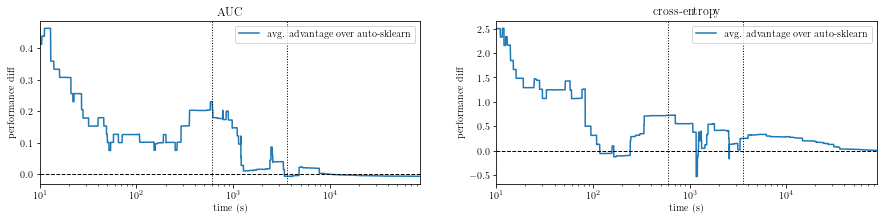

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
for comp in ["auto-sklearn"]:#, "gama"]:
    ax[0].plot(diff_curves["times"], comparison_summary_auc[comp], label="avg. advantage over " + comp)
    ax[1].plot(diff_curves["times"], comparison_summary_logloss[comp], label="avg. advantage over " + comp)
for i, title in enumerate(["AUROC", "cross-entropy"]):
    ax[i].axhline(0, linestyle="--", color="black", linewidth=1)
    ax[i].set_xscale("log")
    ax[i].set_xlim([10, 86400])
    ax[i].legend()
    ax[i].set_xlabel("time (s)")
    ax[i].set_ylabel("performance diff")
    ax[i].axvline(600, linestyle="dotted", color="black", linewidth=1)
    ax[i].axvline(3600, linestyle="dotted", color="black", linewidth=1)
    ax[i].set_title(title)
fig.savefig("plots/advantage-sklearn.jpg", bbox_inches='tight')

# Result Visualizations In Main Paper

## Avg Rank Plots Over Time and Final Performances

In [8]:
def plot_ranks(avg_rank_curves, ax, algorithm_order = None, log_scale = True):
    algos = avg_rank_curves[0] if algorithm_order is None else algorithm_order
    times = avg_rank_curves[1]
    mean_curves = avg_rank_curves[2]
    q1_curves = avg_rank_curves[3]
    q3_curves = avg_rank_curves[4]
    
    for algo in algos:
        index = avg_rank_curves[0].index(algo)
        ax.plot(times, mean_curves[:,index], label=OPTIMIZER_NAMES[algo])
        ax.fill_between(times, q1_curves[:,index], q3_curves[:,index], alpha=0.2)
    ax.legend()
    ax.set_ylim([1, len(algos)])
    if log_scale:
        ax.set_xlim([100, times[-1] + 300])
        ax.set_xscale("log")

In [9]:
def get_final_results(df, timeout):
    df = df[df["timeout"] == timeout]
    algos = list(pd.unique(df["algorithm"]))
    
    results = {}
    
    for openmlid, dfDataset in df.groupby("openmlid"):
        metric = metrics[openmlid]
        if not metric in results:
            results[metric] = {}
        results[metric][openmlid] = {}
        for algo in algos:
            results[metric][openmlid][algo] = dfDataset[dfDataset["algorithm"] == algo]["metric"].values
            
    return results

def plot_final_results_as_boxplot_per_dataset(results, ax_auc, ax_logloss):
    
    from pylab import setp
    
    for metric in ["auc", "log_loss"]:
        for openmlid in results[metric]:
            boxplots = []
            labels = []
            for algo in results[metric][openmlid]:
                boxplots.append(results[metric][openmlid][algo])
                labels.append(OPTIMIZER_NAMES[algo])
            fig, ax = plt.subplots()
            ax.boxplot(boxplots)
            ax.set_title(str(openmlid) + " (" + metric + ")")
            ax.set_xticklabels(labels)
            plt.show()

def plot_final_results_as_rank_boxplot(results, algos, ax):
    
    all_ranks = []
    for metric in ["auc", "log_loss"]:
        for openmlid in results[metric]:
            scores = []
            for algo in algos:
                score = np.nanmedian(results[metric][openmlid][algo])
                score = np.round(score, 2)# if metric == "auc" else 1)
                scores.append(score)
                
            data_to_rank = np.array(scores) if metric is "log_loss" else -np.array(scores)
            ranks = list(scipy.stats.rankdata(data_to_rank))
            all_ranks.append(ranks)
        
    # create plot
    ax.violinplot(np.array(all_ranks), showmedians=True)
    ax.set_xticks(range(1, 1 + len(algos)))
    ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
        
def plot_final_results_as_rank_boxplot_per_metric(results, ax_auc, ax_logloss):
    
    from pylab import setp
    
    for metric in ["auc", "log_loss"]:
        all_ranks = []
        algos = None
        for openmlid in results[metric]:
            scores = []
            algos_here = []
            for algo in results[metric][openmlid]:
                score = np.nanmedian(results[metric][openmlid][algo])
                score = np.round(score, 2)
                scores.append(score)
                algos_here.append(algo)
            if algos is None:
                algos = algos_here
            elif algos != algos_here:
                raise Exception("Inconsistent algorithm order!")
                
            data_to_rank = np.array(scores) if metric is "log_loss" else -np.array(scores)
            ranks = list(scipy.stats.rankdata(data_to_rank))
            all_ranks.append(ranks)
        
        # create plot
        ax = ax_auc if metric == "auc" else ax_logloss
        ax.violinplot(np.array(all_ranks))
        ax.set_title(metric)
        ax.set_xticks(range(1, 1 + len(algos)))
        ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
        
def get_plot_ofrank_curves_and_violines(avg_rank_curves, algorithm_order, df, timeout, log_scale):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    plot_ranks(avg_rank_curves, ax1, algorithm_order=algorithm_order, log_scale=log_scale)
    ax1.set_ylabel("Validation Rank")
    ax1.set_xlabel("Runtime (s)")
    plot_final_results_as_rank_boxplot(get_final_results(df[df["algorithm"].isin(algorithm_order)], timeout), algorithm_order, ax2)
    ax2.set_ylabel("Test Rank")
    fig.tight_layout()
    return fig, (ax1, ax2)
    

In [11]:
performance_curves_1d

{3: {'auto-sklearn': {'times': array([   23,    24,    25,    26,    27,    28,   123,   161,   166,
            196,   217,   307,   620,   657,   676,   705,   779,   933,
           1012,  1030,  1090,  1159,  1195,  1295,  1885,  1921,  1930,
           1934,  1941,  2013,  2229,  2264,  2285,  2838,  3119,  3154,
           3189,  3237,  3725,  3996,  4089,  4346,  4357,  4784,  5346,
           5418,  5499,  5549,  5726,  5842,  6046,  6058,  6525,  6916,
           7833,  8643,  9736, 10356, 10559, 10567, 11006, 11229, 11751,
          11940, 13509, 15148, 16037, 16222, 16741, 17254, 17338, 17804,
          18104, 19470, 19637, 19769, 21055, 22141, 22611, 25074, 25686,
          25689, 29039, 30812, 31208, 40337, 41686, 46781, 47478, 49123,
          50498, 54789, 56822, 60098, 63401, 73503, 74608, 77920, 79201,
          81860, 81932, 82323, 86400]),
   'mean': array([      -inf,       -inf,       -inf,       -inf,       -inf,
          0.9991835 , 0.99918435, 0.99919083, 0.999

### 1h Time Limit

In [10]:
rank_curves_1h = get_rank_curves(performance_curves_1h)

  0%|          | 0/10437 [00:00<?, ?it/s]

KeyboardInterrupt: 

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


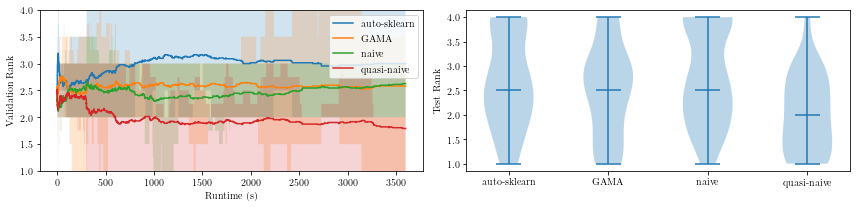

In [11]:
fig = get_plot_ofrank_curves_and_violines(rank_curves_1h, OPTIMIZERS, dfResults, 3600, False)[0]
fig.savefig("plots/ranks-1h.pdf")
plt.show()

### 1d Time Limit

In [12]:
rank_curves_1d = get_rank_curves(performance_curves_1d)

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


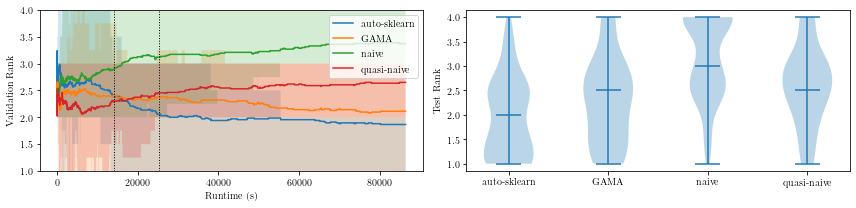

In [13]:
fig, (ax1, ax2) = get_plot_ofrank_curves_and_violines(rank_curves_1d, OPTIMIZERS, dfResults, 86400, False)
ax1.axvline(14000, linestyle="dotted", linewidth=1, color="black")
ax1.axvline(25200, linestyle="dotted", linewidth=1, color="black")
fig.savefig("plots/ranks-1d.pdf")
plt.show()

## Empirical Gaps

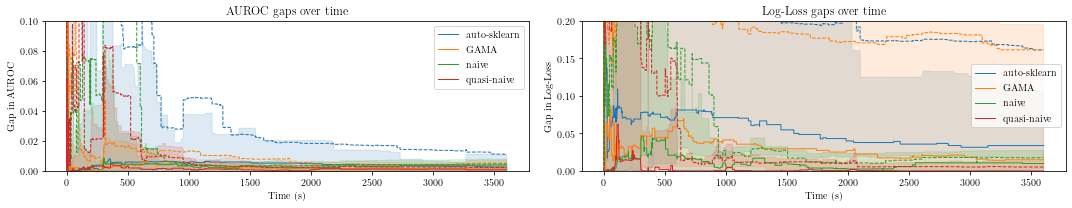

In [14]:
def plot_empirical_gaps_over_time(performance_curves, ax):
    
    curves_for_auc = performance_curves
    algos, times = get_algos_and_times_for_curveset(curves_for_auc)
    datasets = curves_for_auc.keys()
    
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in algos} for openmlid in datasets}
    sup_curves = {openmlid: [] for openmlid in datasets}
    pointwise_gap_curves_mean = {algo: [] for algo in algos}
    pointwise_gap_curves_median = {algo: [] for algo in algos}
    pointwise_gap_curves_q1 = {algo: [] for algo in algos}
    pointwise_gap_curves_q3 = {algo: [] for algo in algos}
    
    for t_index, t in enumerate(times):
        gaps_at_t = {}
        for openmlid, performance_curves_of_dataset in curves_for_auc.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algorithm, curve in performance_curves_of_dataset.items():
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    cur_vals[algorithm] = curve["median"][index_of_timestamp]
            
            best_value_at_t = max(cur_vals.values())
            gaps_at_t[openmlid] = {algorithm: min(1, best_value_at_t - cur_vals[algorithm]) if best_value_at_t > -np.inf else 0 for algorithm in algos}
            sup_curves[openmlid].append(best_value_at_t)
            
        for algo in algos:
            gaps_of_algo_at_time = [gaps_at_t[openmlid][algo] for openmlid in datasets]
            pointwise_gap_curves_median[algo].append(np.median(gaps_of_algo_at_time))
            pointwise_gap_curves_mean[algo].append(scipy.stats.trim_mean(gaps_of_algo_at_time, 0.1))
            pointwise_gap_curves_q1[algo].append(np.percentile(gaps_of_algo_at_time, 25))
            pointwise_gap_curves_q3[algo].append(np.percentile(gaps_of_algo_at_time, 75))
    
    for algo in algos:
        color = OPTIMIZER_COLORS[algo]
        ax.step(times, pointwise_gap_curves_median[algo], label=OPTIMIZER_NAMES[algo], color=color, linewidth=1)
        ax.step(times, pointwise_gap_curves_mean[algo], linestyle="--", color=color, linewidth=1)
        ax.fill_between(times, pointwise_gap_curves_q1[algo], pointwise_gap_curves_q3[algo], color=color, alpha=0.15)

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
plot_empirical_gaps_over_time({openmlid: performance_curves_1h[openmlid] for openmlid in datasets_auc}, ax[0])
plot_empirical_gaps_over_time({openmlid: performance_curves_1h[openmlid] for openmlid in datasets_logloss}, ax[1])
ax[0].legend()
ax[0].set_ylim([0, 0.1])
ax[0].set_ylabel("Gap in AUROC")
ax[0].set_xlabel("Time (s)")
ax[0].set_title("AUROC gaps over time")
ax[1].legend()
ax[1].set_ylim([0, 0.2])
ax[1].set_ylabel("Gap in Log-Loss")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Log-Loss gaps over time")
fig.tight_layout()
fig.savefig("plots/gaps-over-time-1h.pdf")
plt.show()
#{openmlid: performance_curves_1h[openmlid] for openmlid in datasets_logloss}

## Absolute Wins Over Time

In [15]:
def plot_absolute_wins_over_time(performance_curves, algo_1, algo_2, ax):
    win_curves = get_win_curves(performance_curves, algo_1, algo_2)
    ax.step(win_curves[0], win_curves[1][0], label=OPTIMIZER_NAMES[algo_1], color=OPTIMIZER_COLORS[algo_1])
    ax.step(win_curves[0], win_curves[1][1], label=OPTIMIZER_NAMES[algo_2], color=OPTIMIZER_COLORS[algo_2])
    ax.legend()
    ax.set_ylim([0, 70])

def get_fig_for_wins(performance_curves, log_scale=False):
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    for i, competitor in enumerate(["auto-sklearn", "gama"]):
        plot_absolute_wins_over_time(performance_curves, competitor, "naive-python", ax[i][0])
        plot_absolute_wins_over_time(performance_curves, competitor, "seminaive-python", ax[i][1])
        for j in range(2):
            ax[i][j].set_ylabel("Absolute Wins")
            ax[i][j].set_xlabel("Time (s)")
            if log_scale:
                ax[i][j].set_xscale("log")
                ax[i][j].set_xlim([300, 86500])
    fig.tight_layout()
    plt.show()
    return fig

### 1h Time Out

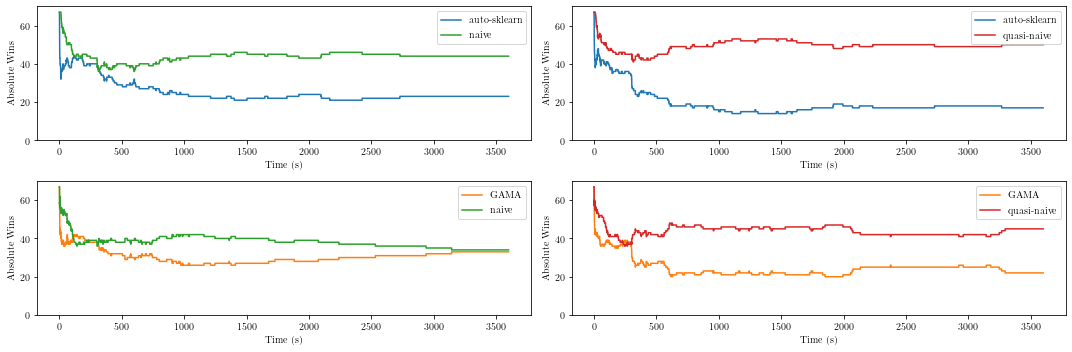

In [16]:
fig = get_fig_for_wins(performance_curves_1h)
fig.savefig("plots/wins-1h.pdf")

### 1d Time Out
#### Standard Scale

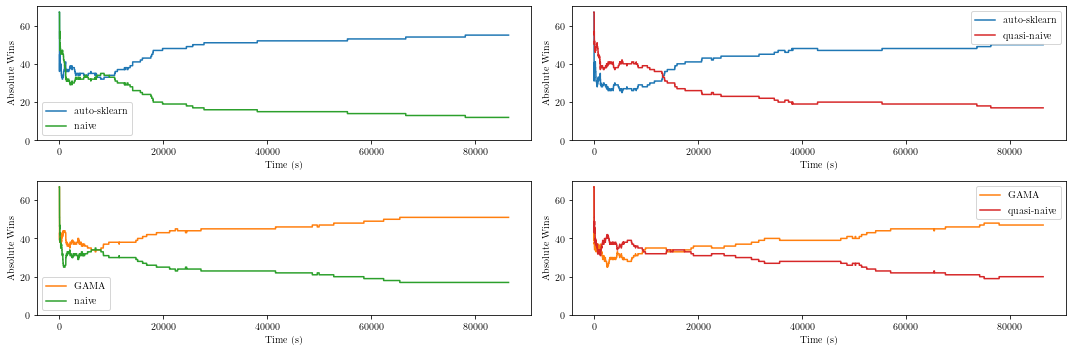

In [17]:
fig = get_fig_for_wins(performance_curves_1d)
fig.savefig("plots/wins-1d.pdf")

#### Log-Scale

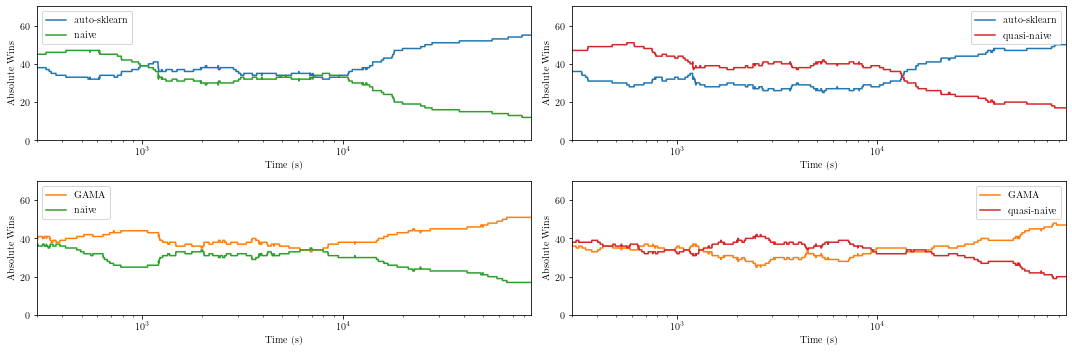

In [18]:
fig = get_fig_for_wins(performance_curves_1d, True)
fig.savefig("plots/wins-1d-log.pdf")

## Test Performance Gaps to Best

In [19]:
def get_optimality_gaps(df):
    gaps = {}
    for openmlid, dfDataset in df.groupby("openmlid"):
        is_max = metrics[openmlid] == "auc"
        medians = {algorithm: np.nanmedian(dfAlgo["metric"].values) for algorithm, dfAlgo in dfDataset.groupby("algorithm")}
        best_median = max(medians.values()) if is_max else min(medians.values())
        gaps_on_dataset = {algo: best_median - median if is_max else median - best_median for algo, median in medians.items()}
        gaps[openmlid] = gaps_on_dataset
    return gaps

def get_gap_plot_for_computed_gaps(gaps, ax):
    
    # compute gaps per algorithm
    gaps_per_algorithm = {}
    for openmlid, gaps_for_dataset in gaps.items():        
        for algo, gap in gaps_for_dataset.items():
            if not algo in gaps_per_algorithm:
                gaps_per_algorithm[algo] = []
            gaps_per_algorithm[algo].append(gap)
    
    # create violinplot
    algos = list(gaps_per_algorithm.keys())
    ax.violinplot([gaps_per_algorithm[algo] for algo in algos], showmedians=True, quantiles=[[.5, .9] for i in range(len(algos))])
    ax.set_xticks(range(1, len(algos) + 1))
    ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
    

def get_gap_plots(df, timeout):    
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    gaps = get_optimality_gaps(df[dfResults["timeout"] == timeout])
    gaps_for_auc = {openmlid: gaps_of_id for openmlid, gaps_of_id in gaps.items() if metrics[openmlid] == "auc"}
    get_gap_plot_for_computed_gaps(gaps_for_auc, ax[0])
    ax[0].set_ylim([0, 0.1])
    ax[0].set_title("Gaps on AUROC datasets")
    gaps_for_log_loss = {openmlid: gaps_of_id for openmlid, gaps_of_id in gaps.items() if metrics[openmlid] == "log_loss"}
    get_gap_plot_for_computed_gaps(gaps_for_log_loss, ax[1])
    ax[1].set_ylim([0, .2])
    ax[1].set_title("Gaps on log-loss datasets")
    return fig, ax

### 1h Time Limit

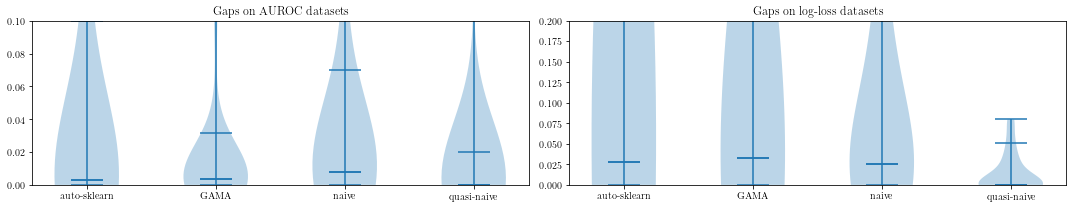

In [20]:
fig = get_gap_plots(dfResults, 3600)[0]
fig.tight_layout()
fig.savefig("plots/gaps-1h.pdf")
plt.show()

### 1d Time Limit

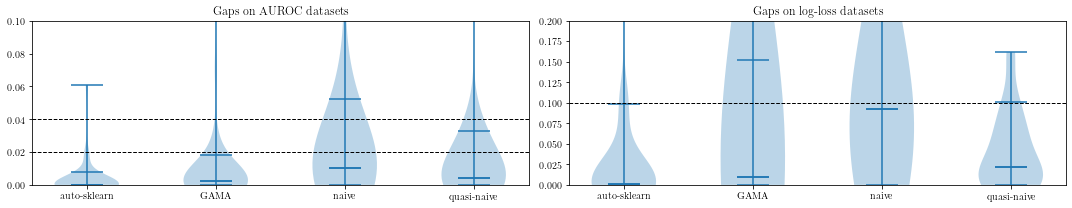

In [21]:
fig, ax = get_gap_plots(dfResults, 86400)
ax[0].axhline(0.02, color="black", linestyle="--", linewidth=1)
ax[0].axhline(0.04, color="black", linestyle="--", linewidth=1)
ax[1].axhline(0.1, color="black", linestyle="--", linewidth=1)
fig.tight_layout()
fig.savefig("plots/gaps-1d.pdf")
plt.show()

# Appendix

## Dataset Descriptions

In [22]:
datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
rows = []
for openmlid in datasets:
    
    # load dataset object
    dataset = openml.datasets.get_dataset(openmlid)
    
    # analyze columns of data
    dfDataset = dataset.get_data()[0]
    types = dfDataset.dtypes
    cnt_normalized = 0
    cnt_zero_mean = 0
    cnt_one_std = 0
    cnt_numerical = 0
    for i, col in enumerate(dfDataset.columns):
        if "float" in str(types[i]):
            cnt_numerical += 1
            vals = dfDataset[col].values
            is_normalized = np.round(min(vals), 3) == 0 and np.round(max(vals), 3) == 1
            is_zero_mean = np.round(np.mean(vals), 3) == 0
            is_one_std = np.round(np.std(vals), 3) == 1
            if is_normalized:
                cnt_normalized += 1
            if is_zero_mean:
                cnt_zero_mean += 1
            if is_one_std:
                cnt_one_std += 1
    if cnt_numerical > 0:
        feature_stats_entries = [str(v) + "\%" for v in np.round(100 * np.array([cnt_normalized / cnt_numerical, cnt_zero_mean / cnt_numerical, cnt_one_std / cnt_numerical]), 0).astype(int)]
    else:
        feature_stats_entries = 3 * ["n/a"]
        
    row = [openmlid, dataset.name[:20].replace("_", "\\_"), int(dataset.qualities["NumberOfInstances"]), len(dataset.features) - 1, int(dataset.qualities["NumberOfNumericFeatures"]), int(dataset.qualities["NumberOfClasses"]), str(int(dataset.qualities["MinorityClassPercentage"])) + "\%", str(int(dataset.qualities["MajorityClassPercentage"])) + "\%", str(int(dataset.qualities["PercentageOfMissingValues"])) + "\%"] + feature_stats_entries
    rows.append(row)
dfDatasets = pd.DataFrame(rows, columns=["openmlid", "name", "instances", "features", "numeric features", "classes", "min \%", "maj \%", "\% missing", "\% [0,1]", "\% $\mu = 0$", "\% $\sigma = 1$"]).sort_values("openmlid")

DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.datase

In [23]:
print(dfDatasets.to_latex(index=False,escape=False))

\begin{tabular}{rlrrrrllllll}
\toprule
 openmlid &                     name &  instances &  features &  numeric features &  classes & min \% & maj \% & \% missing & \% [0,1] & \% $\mu = 0$ & \% $\sigma = 1$ \\
\midrule
        3 &                 kr-vs-kp &       3196 &        36 &                 0 &        2 &   47\% &   52\% &        0\% &      n/a &          n/a &             n/a \\
       12 &            mfeat-factors &       2000 &       216 &               216 &       10 &   10\% &   10\% &        0\% &      n/a &          n/a &             n/a \\
       23 &                      cmc &       1473 &         9 &                 2 &        3 &   22\% &   42\% &        0\% &      n/a &          n/a &             n/a \\
       31 &                 credit-g &       1000 &        20 &                 7 &        2 &   30\% &   70\% &        0\% &      0\% &          0\% &             0\% \\
       54 &                  vehicle &        846 &        18 &                18 &        4 &   

In [24]:
for col in ["instances", "features", "numeric features", "classes", "minority %", "majority %", "% missing vals"]:
    print(col)
    vals = dfDatasets[col]
    if "%" in col:
        vals = [int(v[:v.index("%")]) for v in dfDatasets[col]]
    print("\tMin:", min(vals))
    print("\tMax:", max(vals))
    print("\tQ1:", np.percentile(vals, 25))
    print("\tQ3:", np.percentile(vals, 75))
    print("\tIQR:", np.percentile(vals, 75) - np.percentile(vals, 25))
    print("\tRange:", max(vals) - min(vals))
    print("\tMean:", np.mean(vals))
    print("\tMedian:", np.median(vals))
    print("\tStd:", np.std(vals))

instances
	Min: 100
	Max: 2215023
	Q1: 2209.5
	Q3: 49421.0
	IQR: 47211.5
	Range: 2214923
	Mean: 68253.28358208956
	Median: 5404.0
	Std: 274543.35889177193
features
	Min: 4
	Max: 10000
	Q1: 19.0
	Q3: 244.5
	IQR: 225.5
	Range: 9996
	Mean: 760.0
	Median: 41.0
	Std: 1998.556613487202
numeric features
	Min: 0
	Max: 10000
	Q1: 6.5
	Q3: 204.0
	IQR: 197.5
	Range: 10000
	Mean: 725.8656716417911
	Median: 27.0
	Std: 2001.3987339867217
classes
	Min: 2
	Max: 355
	Q1: 2.0
	Q3: 5.0
	IQR: 3.0
	Range: 353
	Mean: 11.164179104477611
	Median: 2.0
	Std: 44.347540952179465
minority %


KeyError: 'minority %'

## Performances Over Time

In [30]:
def plot_performances_over_time(performance_curves, suffix, algorithm_order = None, ax = None):
    
    def add_curve_to_plot(curve, ax, color, label=None):
        ax.fill_between(curve["times"], curve["q1"], curve["q3"], step="pre", alpha=0.15, color=color)
        ax.step(curve["times"], curve["median"], color=color, label=label)
        ax.step(curve["times"], curve["mean"], color=color, linestyle="--")
    
    last_timestamps_asklearn = []
    last_timestamps_seminaive = []
    axises = {}
    
    if ax is not None and len(performance_curves) > 1:
        raise Exception("Axis object can only be delivered if there is information for a single dataset!")
    
    for openmlid, curves in performance_curves.items():
        metric = metrics[openmlid]
        best_final_value = max([c["median"][-1] if len(c) > 0 and len(c["median"]) > 0 else -np.inf for algo, c in curves.items()])

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 2))
        else:
            fig = None

        all_median_values = []
        
        algos = curves.keys() if algorithm_order is None else algorithm_order
        
        for algorithm in algos:
            curve = curves[algorithm]
            for v in curve["median"]:
                if not np.isnan(v) and v != -np.inf and v != np.inf:
                    all_median_values.append(v)
            if len(curve["times"]) > 0:
                last_timestamps_asklearn.append(curve["times"][-1])
            add_curve_to_plot(curve, ax, OPTIMIZER_COLORS[algorithm], OPTIMIZER_NAMES[algorithm])

        # adjust axis limits
        if suffix == "1d":
            v_min = np.percentile(all_median_values, 5)
            print(openmlid, v_min)
            v_max_theory = 1 if metric == "auc" else 0
            v_max_data = max(all_median_values) + (0.01 if metric == "auc" else 0.1)
            v_max = min(v_max_theory, v_max_data)
            ax.set_ylim([v_min, v_max])
        #ax.legend()
        if not fig is None:
            fig.tight_layout()
            fig.savefig("plots/runs/" + str(openmlid) + "_" + suffix + ".pdf")
        axises[openmlid] = ax

        # plot curve
        #plt.show()
    return axises

### Create Combined Images and Create Latex Code

3 0.9942371885905641


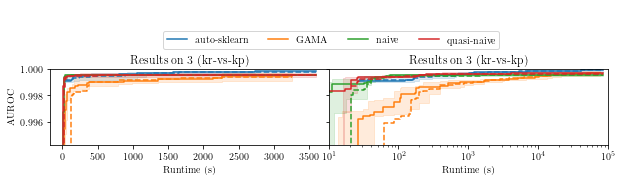

12 -0.36551274307389425


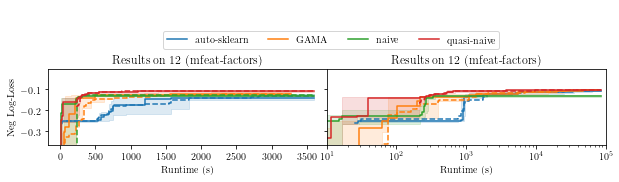

23 -1.1214578813805518


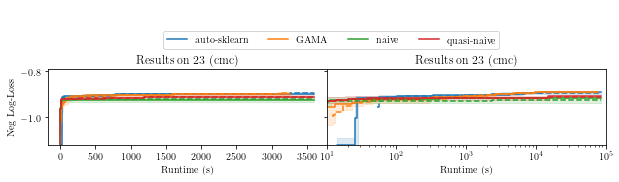

31 0.7533450000000002


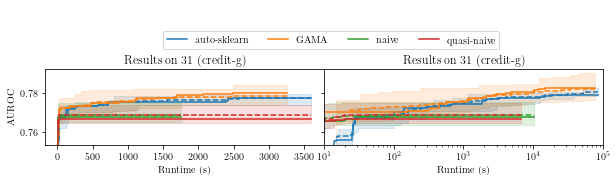

54 -0.641318439116487


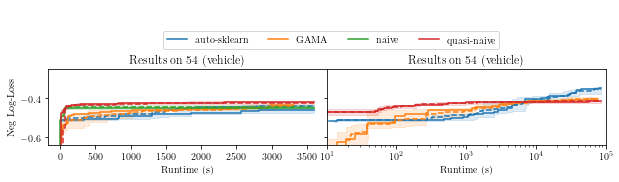

181 -1.4808516839860144


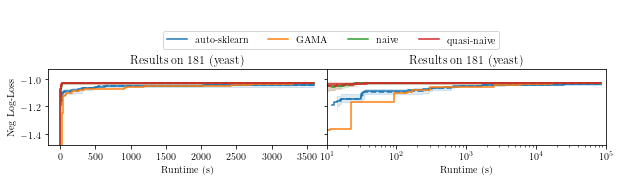

188 -1.742872730846802


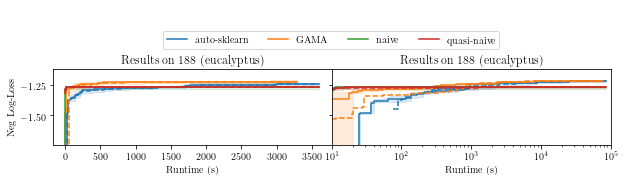

1049 0.8806759873188406


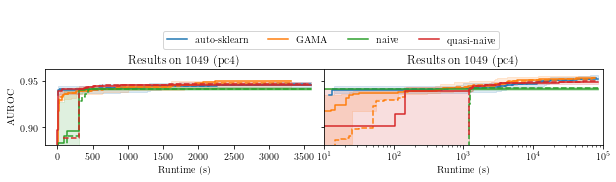

1067 0.7993000000000001


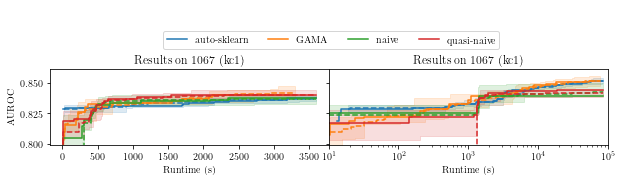

1111 0.5990904455889046


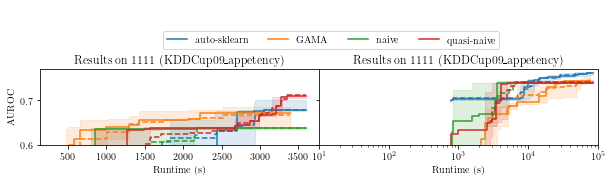

1457 -3.561015006429112


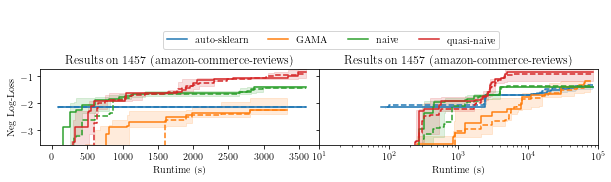

1461 0.7240561118703202


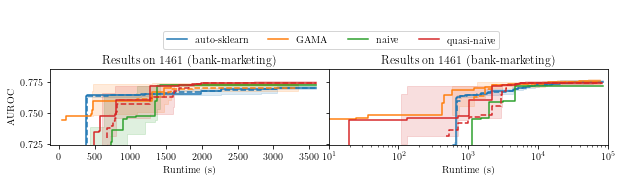

1464 0.6983


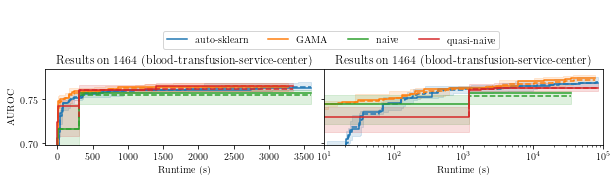

1468 -1.0183325


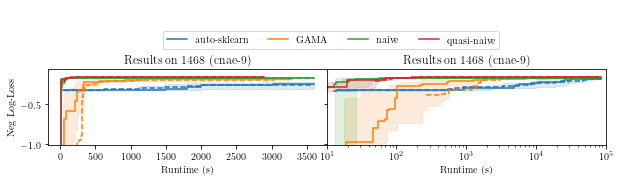

1475 -3.3565549999999993


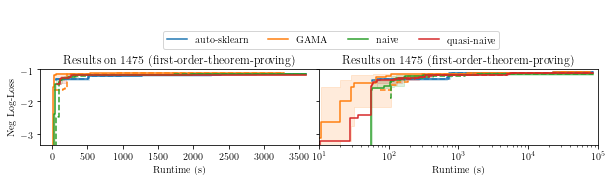

1485 0.735235516655709


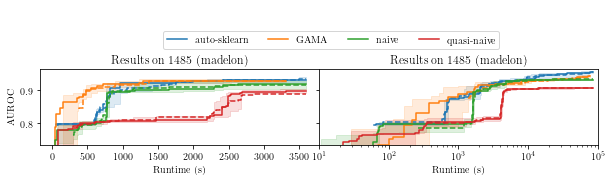

1486 0.9441584511003098


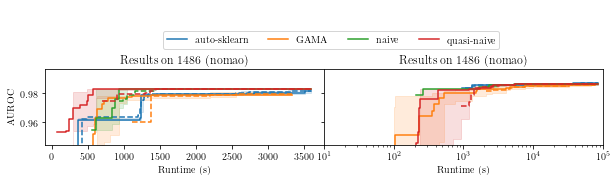

1487 0.8277458765069083


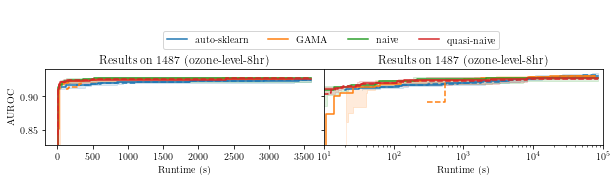

1489 0.8788


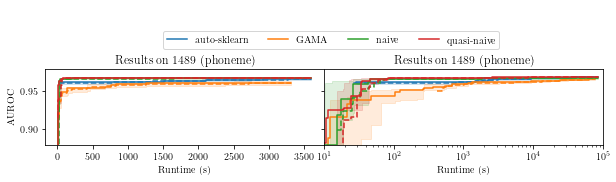

1494 0.9136686843711843


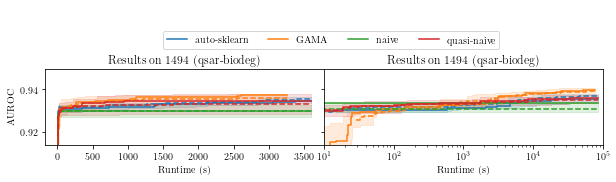

1515 -1.7725


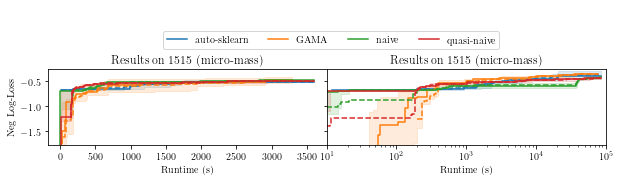

1590 0.871767209727875


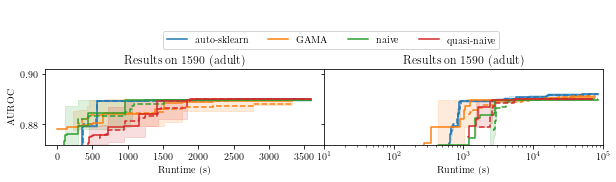

4134 0.7884720665860203


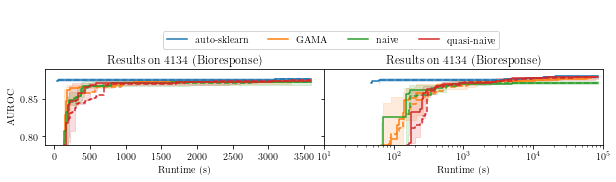

4135 0.765514464306831


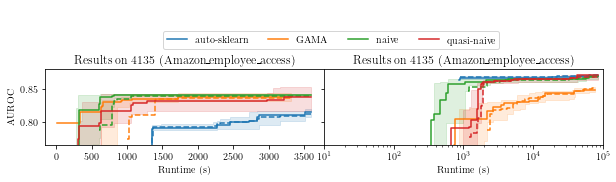

4534 0.9876355593615461


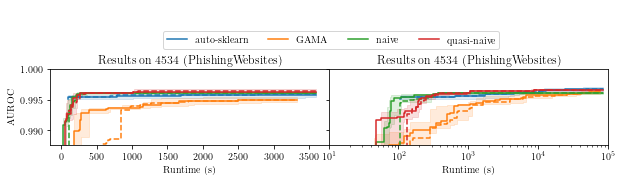

4538 -1.357065449174722


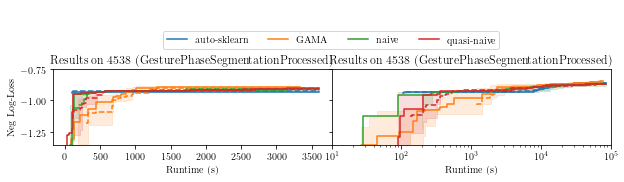

4541 -2.6894825000000004


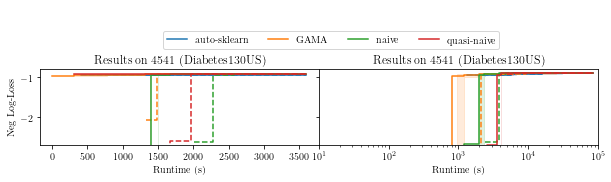

23512 0.6809000000000001


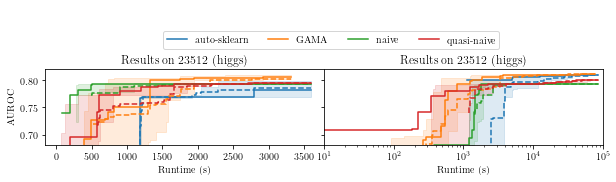

23517 0.5144


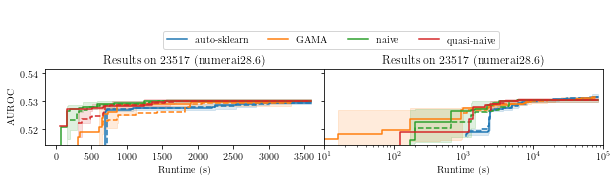

40498 -1.2179025


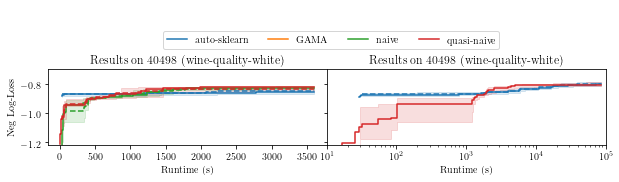

40668 -0.7721296255097986


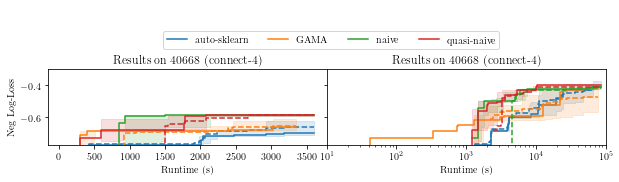

40670 -0.28753457290591944


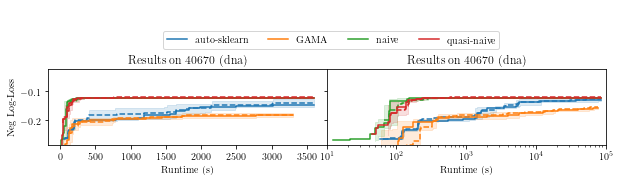

40685 -0.09115652151241782


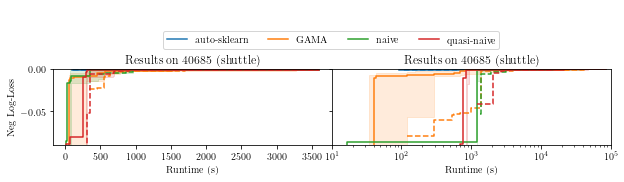

40701 0.7947583832688638


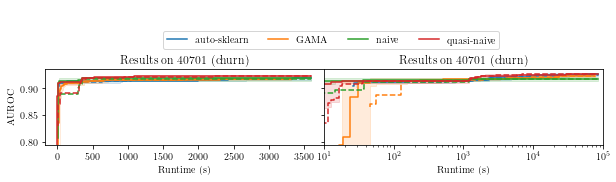

40900 0.9665707427320638


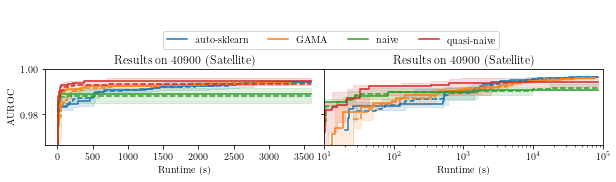

40975 -0.18464818204584116


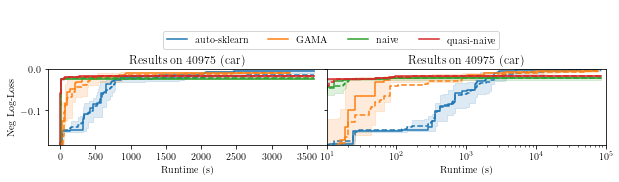

40978 0.9588566869026363


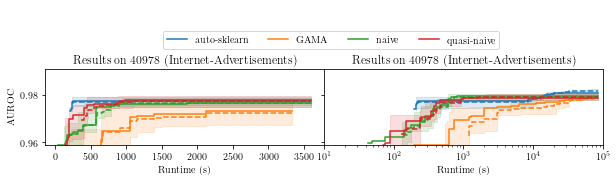

40981 0.9147584033613446


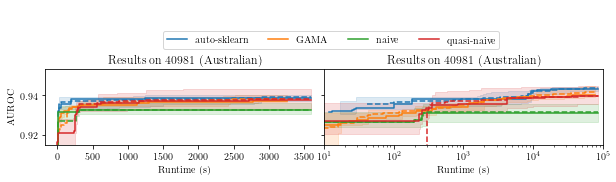

40982 -1.00035


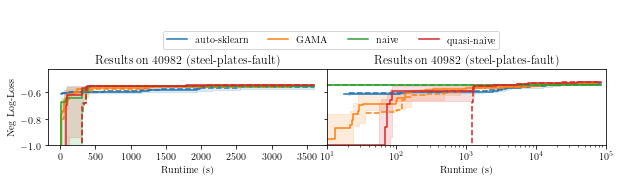

40983 0.9866562827928114


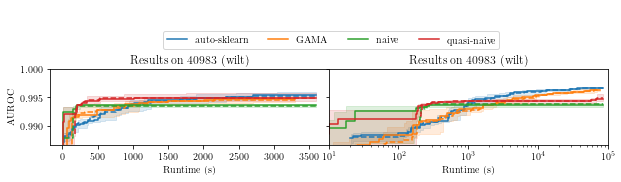

40984 -0.39116999999999996


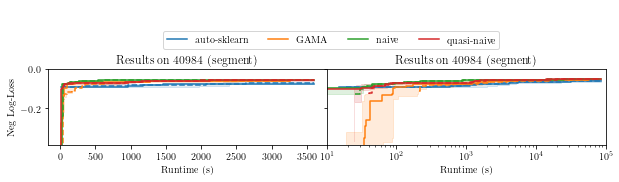

40996 -7.1747499999999995


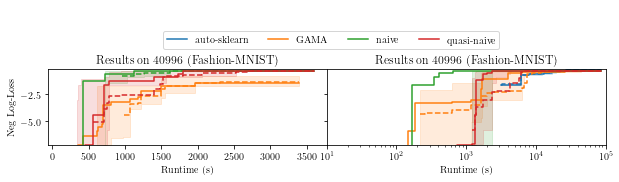

41027 -0.621305909619728


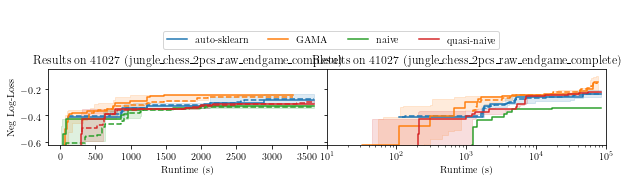

41138 0.9585575000000001


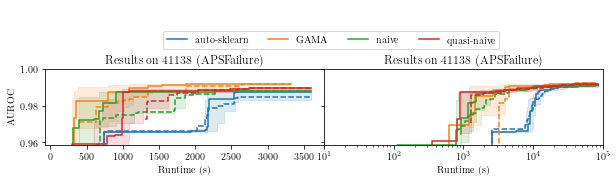

41142 0.7615574603421835


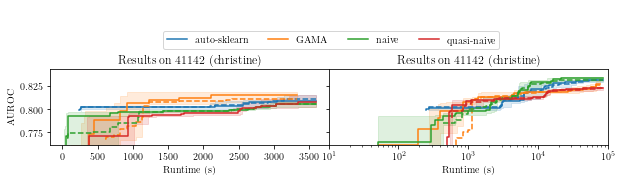

41143 0.8367500000000001


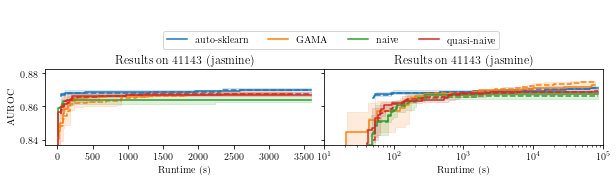

41144 0.7953


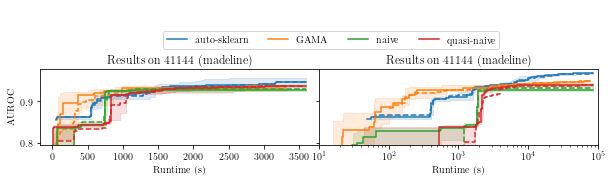

41145 0.7808848374097731


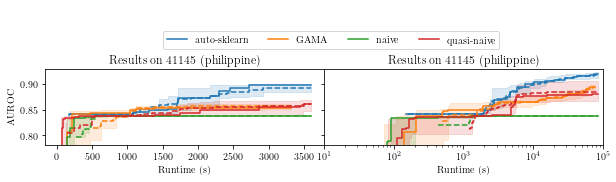

41146 0.95655


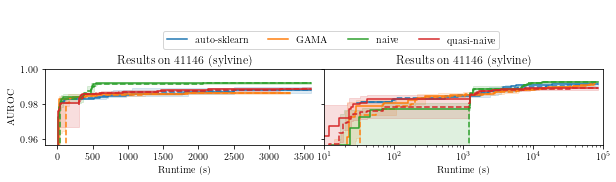

41147 0.53232968804656


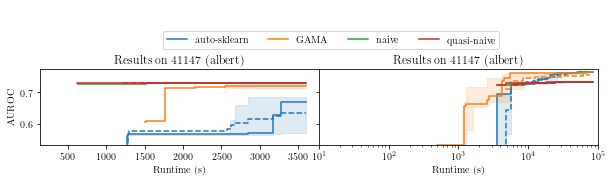

41150 0.8727478848118847


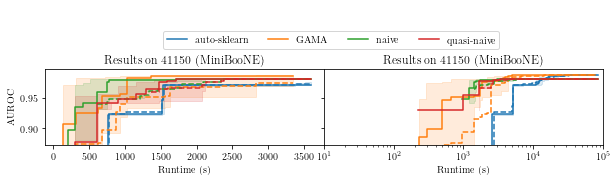

41156 0.874221586004771


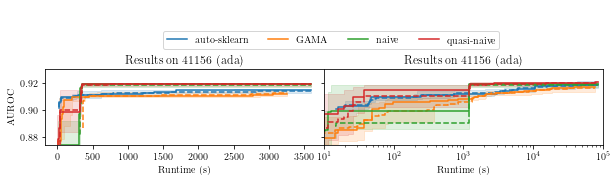

41157 0.7332599999999999


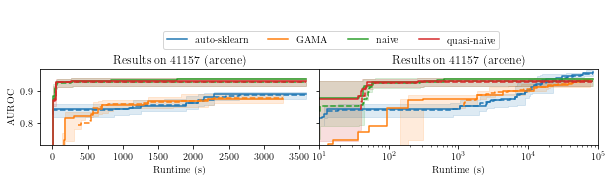

41158 0.8975752043517173


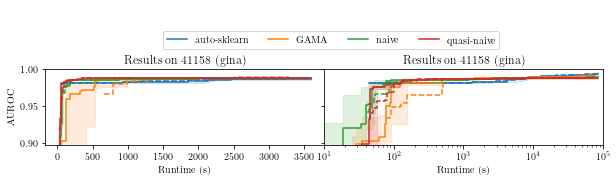

41159 0.5006944444444444


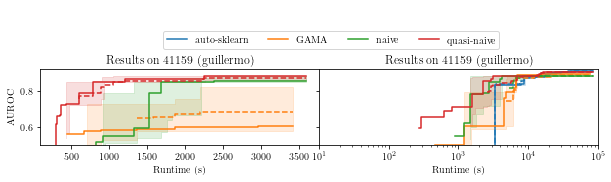

41161 0.7777189135802471


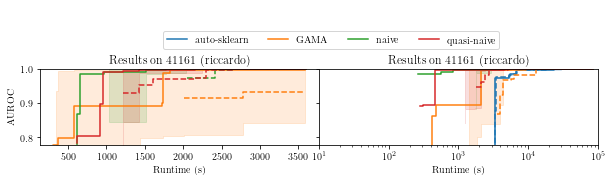

41162 0.34239315132671866


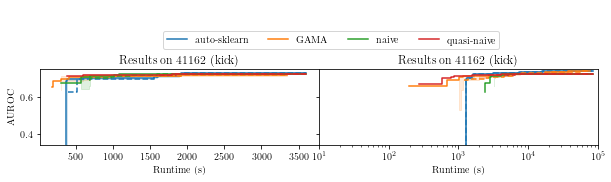

41163 -1.2919897702002947


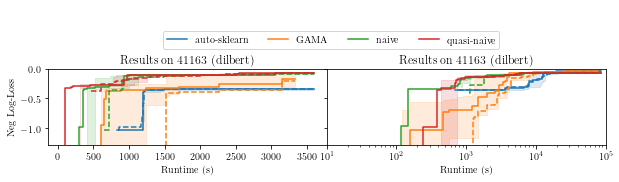

41164 -9.277161990649615


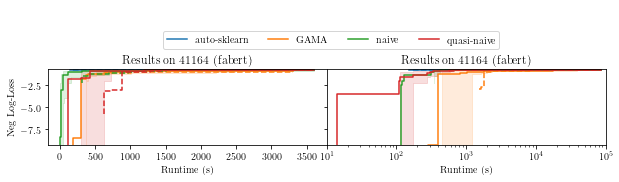

41165 -23.37462


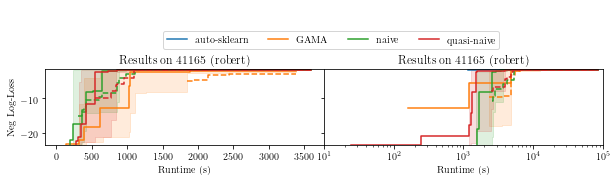

41166 -5.13185


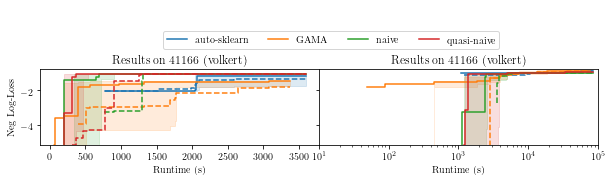

41167 -9.099


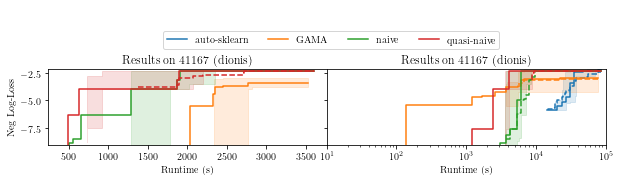

41168 -1.217390338001484


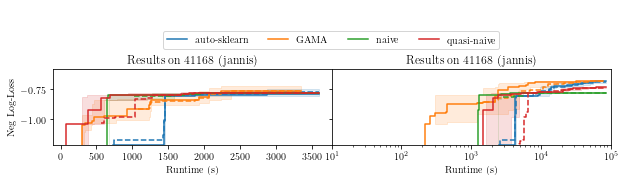

41169 -6.080845


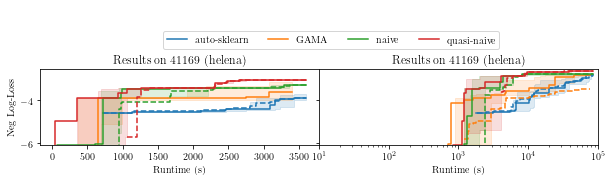

42732 0.3866716449005737


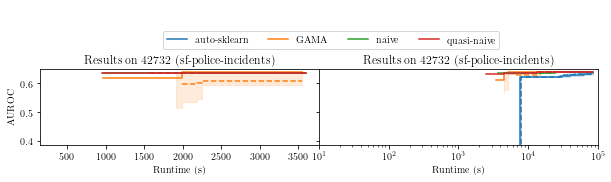

42733 0.5065826432495545


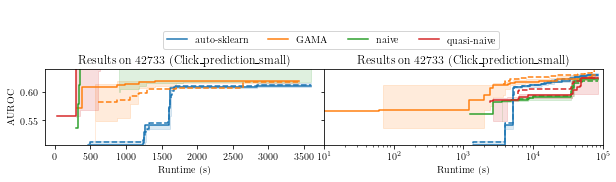

42734 -0.7784100578249062


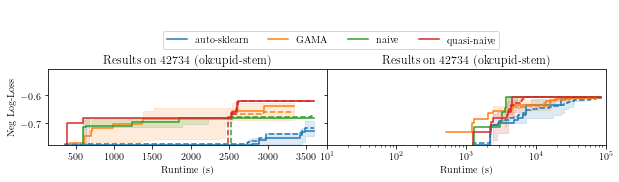

In [40]:
for openmlid in sorted(datasets):
    fig, (ax_1h, ax_1d) = plt.subplots(1, 2, figsize=(10, 1.4), sharey=True)
    relevant_1h = {openmlid: performance_curves_1h[openmlid]}
    relevant_1d = {openmlid: performance_curves_1d[openmlid]}
    plot_performances_over_time(relevant_1h, "1h", algorithm_order=OPTIMIZERS, ax=ax_1h)
    plot_performances_over_time(relevant_1d, "1d", algorithm_order=OPTIMIZERS, ax=ax_1d)
    ax_1h.set_title("Results on " + str(openmlid) + " (" + datasetnames[openmlid].replace("_", "\\_") + ")")
    ax_1h.set_xlabel("Runtime (s)")
    ax_1d.set_title("Results on " + str(openmlid) + " (" + datasetnames[openmlid].replace("_", "\\_") + ")")
    ax_1d.set_xlabel("Runtime (s)")
    ax_1d.set_xscale("log")
    ax_1d.set_xlim([10, 100000])
    ax_1h.set_ylabel("AUROC" if metrics[openmlid] == "auc" else "Neg Log-Loss")
    fig.subplots_adjust(wspace=0)
    handles, labels = ax_1h.get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.46, 1.55),ncol=4)
    fig.savefig("plots/runs/" + str(openmlid) + ".pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [39]:
latex = ""
i = 0
n = 6
for openmlid in sorted(datasets):
    print("\\includegraphics[width=\\textwidth]{fig/runplots/" + str(openmlid) + ".pdf}\\\\[-2em]")

\includegraphics[width=\textwidth]{fig/runplots/3.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/12.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/23.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/31.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/54.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/181.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/188.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/1049.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/1067.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/1111.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/1457.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/1461.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/1464.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/1468.pdf}\\[-2em]
\includegraphics[width=\textwidth]{fig/runplots/1475.pdf}\\[-2em]
\includegraphics[width=

In [28]:
def getResultTable(dfResults, rowAttribute, colAttribute, resultAttribute, col_labels = None, cellFormatter = None, comparativeFormatters = None, row_formatter = None, colnames = None):
    rows = []
    if colnames is None:
        colnames = list(pd.unique(dfResults[colAttribute]))
    for rowIndex, dfRow in dfResults.groupby(rowAttribute):
        
        # identify all scores for row
        scores = {}
        for colName in colnames:
            if colName != rowAttribute:
                scoresForCell = dfRow[(dfRow[colAttribute] == colName) & (dfRow[resultAttribute].notna())][resultAttribute].values
                if len(scoresForCell) == 0:
                    scoresForCell = [np.nan]
                scores[colName] = sorted(scoresForCell)
        
        rows.append([rowIndex] + row_formatter(rowIndex, scores))
    
    with pd.option_context("max_colwidth", 1000):
        return pd.DataFrame(rows, columns=[rowAttribute] + [col_labels[col] if not col_labels is None and col in col_labels else col for col in colnames])

In [32]:
def get_default_best_formatting(scores, indices, is_minimize, relevance_gap):
    cellFormatter = lambda x: str(np.round(scipy.stats.trim_mean(x, 0.1), 2)) + "$\pm$" + str(np.round(np.nanstd(x), 2)) if len([y for y in x if not np.isnan(y)]) > 0 else "nan"
    
    # get best score (and column name)
    bestMean = None
    bestCol = None
    for colName in scores:
        scoresForCell = scores[colName]
        meanScore = scipy.stats.trim_mean(scoresForCell, 0.1)
        if ~np.isnan(meanScore) and (bestCol is None or (is_minimize and bestMean > meanScore or not is_minimize and bestMean < meanScore)):
            bestMean = meanScore
            bestCol = colName
    
    # now apply formatters to cells and add them to row
    bestScores = scores[bestCol] if not bestCol is None else []
    
    # formatting of best cells
    row = []
    if bestMean is None:
        for colName in indices:
            row.append("nan")
    else:
        for colName in indices:
            scoresForCell = scores[colName]
            curMean = scipy.stats.trim_mean(scoresForCell, 0.1)
            isBest = ((bestCol == colName) | (np.round(curMean, 2) == np.round(bestMean, 2)))
            if not isBest:
                n = min(len(bestScores), len(scoresForCell))
                if n > 0:
                    if n > 1:
                        wilcoxon = sp.stats.wilcoxon(bestScores[:n], scoresForCell[:n])
                        isSignificant = wilcoxon.pvalue < 0.05
                        isRelevant = np.round(np.abs(np.round(bestMean, 2) - np.round(curMean, 2)), 2) > relevance_gap
                    else:
                        isSignificant = False
                        isRelevant = False
                else:
                    isSignificant = True
                    isRelevant = True
            entry = cellFormatter(scoresForCell)
            if isBest:
                entry = "\\textbf{" + str(entry) + "}"
            elif entry != "nan" and not (isSignificant and isRelevant):
                entry = "\\underline{" + str(entry) + "}"
            row.append(entry)
    return row

def get_row_layouter(is_minimize, relevance_gap):

    def row_layouter(openmlid, scores):

        indices = [x for x in scores]
        row = get_default_best_formatting(scores, indices, is_minimize, relevance_gap)

        '''
        # we now have one (formatted) entry for each column. Now add bullet/circ symbols
        naive_cols = [x for x in scores if "naive" in x]
        competitor_cols = [x for x in scores if not "naive" in x]
        for naive_col in naive_cols:
            scores_naive = scores[naive_col]
            mean_naive = np.round(scipy.stats.trim_mean(scores_naive, 0.1), 2)
            for competitor_col in competitor_cols:
                scores_competitor = scores[competitor_col]
                mean_competitor = np.round(scipy.stats.trim_mean(scores_competitor, 0.1), 2)
                n = min(len(scores_naive), len(scores_competitor))
                if n > 1 and scores_naive[:n] != scores_competitor[:n]:
                    wilcoxon = sp.stats.wilcoxon(scores_naive[:n], scores_competitor[:n])
                    isSignificant = wilcoxon.pvalue < 0.05
                else:
                    isSignificant = False

                diff = np.round(mean_competitor - mean_naive, 2)

                is_substantially_better = isSignificant and ((is_minimize and diff > 0.01) or (not is_minimize and diff < -0.01))
                is_substantially_worse = isSignificant and ((is_minimize and diff < -0.01) or (not is_minimize and diff > 0.01))
                i = indices.index(competitor_col)
                if is_substantially_worse:
                    row[i] += " $\\circ$"
                elif is_substantially_better:
                    row[i] += " $\\bullet$"

                else:
                    row[i] += " \\phantom{$\\circ$}"
        '''
        return row

    return row_layouter


latex_colname_map = {
    "openmlid": "id"
}

## Results for 1h Timeout

### AUROC

In [33]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 3600) & (dfResults["openmlid"].isin(datasets_auc))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(False, 0.01), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

\begin{tabular}{r||rrrr}
\toprule
 \multicolumn{1}{c}{id} & \multicolumn{1}{c}{auto-sklearn} &   \multicolumn{1}{c}{GAMA} &  \multicolumn{1}{c}{naive} & \multicolumn{1}{c}{quasi-naive} \\
\midrule
                      3 &             \textbf{1.0$\pm$0.0} &       \textbf{1.0$\pm$0.0} &       \textbf{1.0$\pm$0.0} &            \textbf{1.0$\pm$0.0} \\
                     31 &           \textbf{0.78$\pm$0.04} &     \textbf{0.78$\pm$0.05} &              0.75$\pm$0.09 &       \underline{0.77$\pm$0.05} \\
                   1049 &        \underline{0.94$\pm$0.02} &     \textbf{0.95$\pm$0.02} &              0.91$\pm$0.04 &          \textbf{0.95$\pm$0.02} \\
                   1067 &        \underline{0.83$\pm$0.02} &  \underline{0.83$\pm$0.03} &     \textbf{0.84$\pm$0.03} &          \textbf{0.84$\pm$0.02} \\
                   1111 &        \underline{0.68$\pm$0.03} &              0.67$\pm$0.06 &              0.63$\pm$0.02 &          \textbf{0.69$\pm$0.03} \\
                   1461 &        

/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2958: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2972: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Log-Loss

In [34]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 3600) & (dfResults["openmlid"].isin(datasets_logloss))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(True, 0.1), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

\begin{tabular}{r||rrrr}
\toprule
 \multicolumn{1}{c}{id} & \multicolumn{1}{c}{auto-sklearn} &   \multicolumn{1}{c}{GAMA} &  \multicolumn{1}{c}{naive} & \multicolumn{1}{c}{quasi-naive} \\
\midrule
                     12 &           \textbf{0.13$\pm$0.06} &  \underline{0.17$\pm$7.05} &  \underline{1.54$\pm$5.17} &          \textbf{0.13$\pm$0.04} \\
                     23 &           \textbf{0.91$\pm$0.04} &     \textbf{0.91$\pm$0.04} &              2.02$\pm$3.08 &       \underline{0.94$\pm$0.22} \\
                     54 &        \underline{0.47$\pm$0.06} &  \underline{0.44$\pm$7.79} &              1.05$\pm$0.36 &          \textbf{0.42$\pm$0.05} \\
                    181 &           \textbf{1.05$\pm$0.08} &  \underline{1.13$\pm$0.19} &  \underline{1.09$\pm$0.19} &       \underline{1.07$\pm$0.08} \\
                    188 &           \textbf{1.15$\pm$0.07} &  \underline{1.16$\pm$0.07} &              1.28$\pm$0.09 &       \underline{1.21$\pm$0.07} \\
                   1457 &        

## 1d Time Limit

### AUROC

In [35]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 86400) & (dfResults["openmlid"].isin(datasets_auc))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(False, 0.01), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

\begin{tabular}{r||rrrr}
\toprule
 \multicolumn{1}{c}{id} & \multicolumn{1}{c}{auto-sklearn} &   \multicolumn{1}{c}{GAMA} &  \multicolumn{1}{c}{naive} & \multicolumn{1}{c}{quasi-naive} \\
\midrule
                      3 &             \textbf{1.0$\pm$0.0} &       \textbf{1.0$\pm$0.0} &      \textbf{1.0$\pm$0.03} &            \textbf{1.0$\pm$0.0} \\
                     31 &        \underline{0.77$\pm$0.05} &     \textbf{0.78$\pm$0.05} &  \underline{0.77$\pm$0.05} &       \underline{0.77$\pm$0.05} \\
                   1049 &           \textbf{0.95$\pm$0.02} &     \textbf{0.95$\pm$0.02} &  \underline{0.92$\pm$0.05} &       \underline{0.94$\pm$0.03} \\
                   1067 &           \textbf{0.85$\pm$0.02} &              0.83$\pm$0.03 &   \underline{0.8$\pm$0.04} &                   0.81$\pm$0.04 \\
                   1111 &           \textbf{0.77$\pm$0.02} &               0.7$\pm$0.04 &              0.71$\pm$0.03 &                   0.74$\pm$0.02 \\
                   1461 &        

/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2958: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2972: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Log-Loss

In [36]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 86400) & (dfResults["openmlid"].isin(datasets_logloss))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(True, 0.1), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

\begin{tabular}{r||rrrr}
\toprule
 \multicolumn{1}{c}{id} & \multicolumn{1}{c}{auto-sklearn} &   \multicolumn{1}{c}{GAMA} &  \multicolumn{1}{c}{naive} & \multicolumn{1}{c}{quasi-naive} \\
\midrule
                     12 &           \textbf{0.12$\pm$0.06} &              0.47$\pm$0.96 &              1.45$\pm$5.03 &       \underline{0.13$\pm$0.05} \\
                     23 &            \textbf{0.9$\pm$0.04} &  \underline{0.91$\pm$0.04} &              2.73$\pm$5.54 &       \underline{0.93$\pm$0.06} \\
                     54 &           \textbf{0.36$\pm$0.04} &              3.7$\pm$10.47 &                        nan &       \underline{0.43$\pm$0.11} \\
                    181 &           \textbf{1.05$\pm$0.05} &  \underline{4.04$\pm$8.23} &              1.18$\pm$0.23 &       \underline{1.06$\pm$0.09} \\
                    188 &           \textbf{1.12$\pm$0.07} &  \underline{1.16$\pm$0.06} &                1.3$\pm$0.1 &       \underline{1.19$\pm$0.07} \\
                   1457 &        

# Other insights not contained in the paper

## Selections Made

In [ ]:
import re

def visualize_selections_on_dataset(dfResults, openmlid):
    
    # gathering information
    occurring = set([])
    selections = {}
    for algorithm, dfAlgo in dfResults[dfResults["openmlid"] == openmlid].groupby("algorithm"):
        if not algorithm in selections:
            selections[algorithm] = {}
        if algorithm == "auto-sklearn":
            for i, row in dfAlgo.iterrows():
                chosen_model = row["chosenmodel"]
                chosen_model = chosen_model[chosen_model.index("SimpleClassificationPipeline(") + len("SimpleClassificationPipeline("):-6]
                chosen_model = chosen_model[:chosen_model.rindex("{")]
                chosen_model = chosen_model[:chosen_model.rindex("}") + 1]
                chosen_model = ast.literal_eval(chosen_model)
                for key, val in chosen_model.items():
                    if "__choice__" in key and val != "none":
                        occurring.add(val)
                        if not val in selections[algorithm]:
                            selections[algorithm][val] = 0
                        selections[algorithm][val] += 1
        
        if "naive" in algorithm:
            for i, row in dfAlgo.iterrows():
                for step in ["data-pre-processor", "feature-pre-processor", "classifier"]:
                    match = re.search("\\('" + step + "',\s([^(]*)", row["chosenmodel"])
                    if match is not None:
                        val = match.group(1)
                        occurring.add(val)
                        if not val in selections[algorithm]:
                            selections[algorithm][val] = 0
                        selections[algorithm][val] += 1
    
    def subcategorybar(X, vals, ax, width=0.8):
        n = len(vals)
        _X = np.arange(len(X))
        for i in range(n):
            ax.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge")   
        ax.set_xticks(range(len(X)))
        ax.set_xticklabels(X, rotation=90)
    
    # plotting histograms
    fig, ax = plt.subplots(figsize=(20, 5))
    occurring = list(occurring)
    counts = [[selections[algorithm][s] if s in selections[algorithm] else 0 for s in occurring] for algorithm in selections.keys()]
    subcategorybar(occurring, counts, ax)
    print(selections.keys())
        
        
visualize_selections_on_dataset(dfResults[dfResults["timeout"] == 86400], 1485)

In [ ]:
wins = {}
for openmlid, dfDataset in dfResults[(dfResults["timeout"] == 86400)].groupby("openmlid"):
    print(openmlid, metrics[openmlid])
    boxes = []
    labels = []
    vmax = None
    vmin = None
    is_max = metrics[openmlid] == "auc"
    medians = [np.nanmedian(dfAlgo["metric"].values) for algorithm, dfAlgo in dfDataset.groupby("algorithm")]
    best_median = max(medians) if is_max else min(medians)
    print("Best score:", best_median)
    
    means = []
    for algorithm, dfAlgo in dfDataset.groupby("algorithm"):
        #if algorithm == "auto-sklearn":
         #   minority_coalescer_counter = 0
            #for j, row in dfAlgo.iterrows():
             #   minority_coalescer_counter += ("minority_coalescer" in row["chosenmodel"])
            #print(minority_coalescer_counter / len(dfAlgo))
        boxes.append(dfAlgo["metric"].values)
        labels.append(algorithm)
        if vmin is None:
            vmin = min(dfAlgo["metric"].values)
            vmax = max(dfAlgo["metric"].values)
        else:
            vmin = min(vmin, min(dfAlgo["metric"].values))
            vmax = max(vmax, max(dfAlgo["metric"].values))
            
        mean = np.nanmean(dfAlgo["metric"].values)
        median = np.nanmedian(dfAlgo["metric"].values)
        win = (median >= best_median and is_max) or (median <= best_median and not is_max)
        if win:
            print("Win for", algorithm)
            if algorithm in wins:
                wins[algorithm] += 1
            else:
                wins[algorithm] = 1
        means.append(mean)
        print("\t" + algorithm, np.round(np.median(dfAlgo["metric"]), 4), "(" + str(np.round(np.std(dfAlgo["metric"]), 4)) + ")")
    
    vmin = min(vmin, vmax - 0.03)
    
    fig, ax = plt.subplots()
    ax.boxplot(boxes)
    for i, mean in enumerate(means):
        ax.axhline(mean, color="C" + str(i))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim([vmin, vmax])
    plt.show()
print(wins)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe535c32a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe535d14890>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe535df0710>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe535c5fcd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe535cc8f90>,
 'means': []}

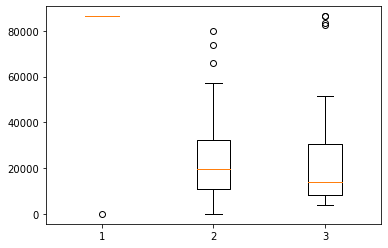

In [276]:
def get_runtimes(performance_curves):
    runtimes = {}
    for openmlid, curves_for_dataset in performance_curves.items():
        runtimes[openmlid] = [c["times"][-1] if len(c["times"]) > 0 else 0 for c in curves_for_dataset]
    return runtimes

vals_asklearn = []
vals_naive = []
vals_semi = []
for _, vals in get_runtimes(performance_curves).items():
    vals_asklearn.append(vals[0])
    if vals[1] != 0:
        vals_naive.append(vals[1])
    if vals[2] != 0:
        vals_semi.append(vals[2])
plt.boxplot([vals_asklearn, vals_naive, vals_semi])

In [51]:
pd.unique(dfResults["algorithm"])

array(['auto-sklearn', 'seminaive-python'], dtype=object)

## Result Table

In [174]:
def get_result_table(df):
    
    rows = []
    algos = list(pd.unique(df["algorithm"]))
    for openmlid, dfDataset in df.groupby("openmlid"):
        row = [openmlid, metrics[openmlid]]
        for algorithm in algos:
            dfAlgo = dfDataset[dfDataset["algorithm"] == algorithm]
            row.append(dfAlgo["metric"].values)
        rows.append(row)
    
    return pd.DataFrame(rows, columns=["openmlid", "metric"] + algos)

def get_formatted_table(table, row_func):
    
    rows = []
    for i, row in table.iterrows():
        rows.append(row_func(row))
    return pd.DataFrame(rows, columns=table.columns)

def my_format(row):
    new_row = []
    for i, val in enumerate(row):
        if i <= 1:
            new_row.append(val)
        else:
            new_row.append(np.nanmedian(val))
    return new_row

df_result_table = get_result_table(dfResults[dfResults["timeout"] == 3600])
df_result_table

,openmlid,metric,auto-sklearn,seminaive-python,naive-python,gama
0,3,auc,"[1.0, 1.0, 0.9999586024176188, 0.9999580466521...","[1.0, 1.0, 0.999793012088094, 1.0, 0.999705275...","[1.0, 1.0, 0.9978059281337971, 1.0, 0.98712535...","[0.9994773028828756, 1.0, 0.999337638681901, 0..."
1,12,log_loss,"[0.16097709980337638, 0.14230992989701247, 0.1...","[0.1125839286356022, 0.15814217616137038, 0.12...","[0.1151652711656102, 0.15055516314859488, 14.4...","[0.15914156784443406, 0.18373019246657704, 0.2..."
2,23,log_loss,"[0.8794201014784631, 0.953651822891606, 0.9377...","[0.8845807115382553, 0.9894136289573484, 0.928...","[1.0652806747300902, 1.2697519880742456, 1.818...","[0.8970617479855751, 0.9541787390654488, 0.943..."
3,31,auc,"[0.7685714285714287, 0.7933333333333334, 0.871...","[0.7476190476190476, 0.7761904761904762, 0.852...","[0.7414285714285714, 0.5, 0.8538095238095238, ...","[0.76, 0.7757142857142857, 0.8666666666666667,..."
4,54,log_loss,"[0.39974096893431377, 0.5099302851216317, 0.42...","[0.36838754101931936, 0.4804562186194406, 0.36...","[1.3530960545111377, 1.3892291400554293, 0.525...","[0.48895403812311106, 0.3304715582085343, 0.42..."
...,...,...,...,...,...,...
61,41167,log_loss,"[5.872117789475415, 5.872117789475415, 5.87211...",[],[],"[3.5945906176953097, 19.289000936099924, 17.78..."
62,41168,log_loss,"[0.7934836218568275, 0.7781800804704431, 0.690...","[0.7998746332348228, 0.7833824930027707, 0.804...","[0.8119243219029633, 0.8031965024705956, 0.829...","[0.7402313133493167, 0.7503984940171213, 0.716..."
63,41169,log_loss,"[3.0957445182613195, 3.957400786213042, 4.0847...","[3.0553906238711708, 3.0603365053145803, 3.090...","[3.238927800091194, 3.252778373356102, 3.28600...","[3.0360680872950154, 3.3026619287157946, 3.948..."
64,42732,auc,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.6394247490297751, 0.6373971216681413, 0.641...","[0.6393099931252609, 0.6371160876726355, 0.641...","[0.6423998919698609, 0.6417314481392036, 0.516..."


In [185]:
for i, row in get_formatted_table(df_result_table, my_format).iterrows():
    if row["metric"] == "log_loss":
        continue
    all_scores = np.array([row["gama"], row["seminaive-python"]])
    best_score = min(all_scores) if row["metric"] == "log_loss" else max(all_scores)
    if best_score >= row["seminaive-python"] + 0.02:
        
        print(row, best_score, all_scores <= best_score if row["metric"] == "log_loss" else all_scores >= best_score)
        #and (row["gama"] >= row["naive-python"] and row["gama"] >= row["seminaive-python"] and row["gama"] >= row["auto-sklearn"]):
        #    print(row)

openmlid                1485
metric                   auc
auto-sklearn        0.931657
seminaive-python    0.913817
naive-python        0.920059
gama                0.937396
Name: 15, dtype: object 0.937396449704142 [ True False]
openmlid                1494
metric                   auc
auto-sklearn         0.93357
seminaive-python     0.91665
naive-python        0.906602
gama                0.937959
Name: 19, dtype: object 0.9379591836734694 [ True False]
openmlid                4135
metric                   auc
auto-sklearn        0.834887
seminaive-python    0.822939
naive-python        0.803552
gama                0.846761
Name: 23, dtype: object 0.8467607116161265 [ True False]
openmlid               40983
metric                   auc
auto-sklearn        0.997326
seminaive-python    0.553307
naive-python        0.570877
gama                0.996995
Name: 39, dtype: object 0.9969949666518327 [ True False]
openmlid               41144
metric                   auc
auto-sklearn       